<a href="https://colab.research.google.com/github/vparro/MLprobabilistico/blob/master/SIRRealDataUK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações básicas

In [677]:
import pylab as pp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy import integrate, interpolate
from scipy import optimize
from scipy.integrate import odeint
from pylab import *
!pip install lmfit
from lmfit import minimize, Parameters, Parameter, report_fit

# Referências

# **Dados Reais - UK**

Dados referentes a cidade de Londres entre 1944 e 1964. População de aproximadamente 2.5 milhões de habitantes na época.

In [678]:
# Lendo o arquivo de dados no formato 'filename.csv'  
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/PG_IMT/DadosEpidemia/London.csv") 
# Preview das cinco primeiras linhas
data.head()

,time,cases,births,pop
0,1944.016427,180,1725.038462,2.462500e+06
1,1944.054757,271,1726.429265,2.467578e+06
2,1944.093087,423,1727.820068,2.472655e+06
3,1944.131417,465,1729.210870,2.477733e+06
4,1944.169747,523,1730.601673,2.482810e+06


In [0]:
s_array = data[["cases", "births", "pop","time"]].to_numpy()
s_array[:,0:]
Id = s_array[:,0]
Bd = s_array[:,1]
Sd = s_array[:,2]
t  =  s_array[:,3]

**Visualizando os dados**

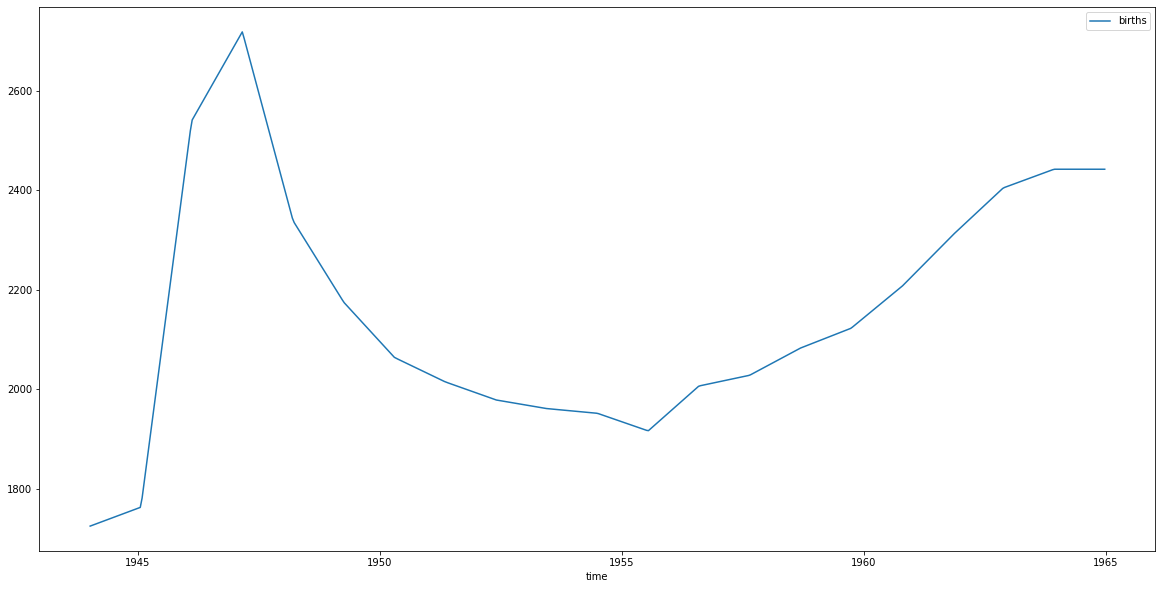

In [680]:
data.plot(x ='time', y='births',figsize=(20,10))

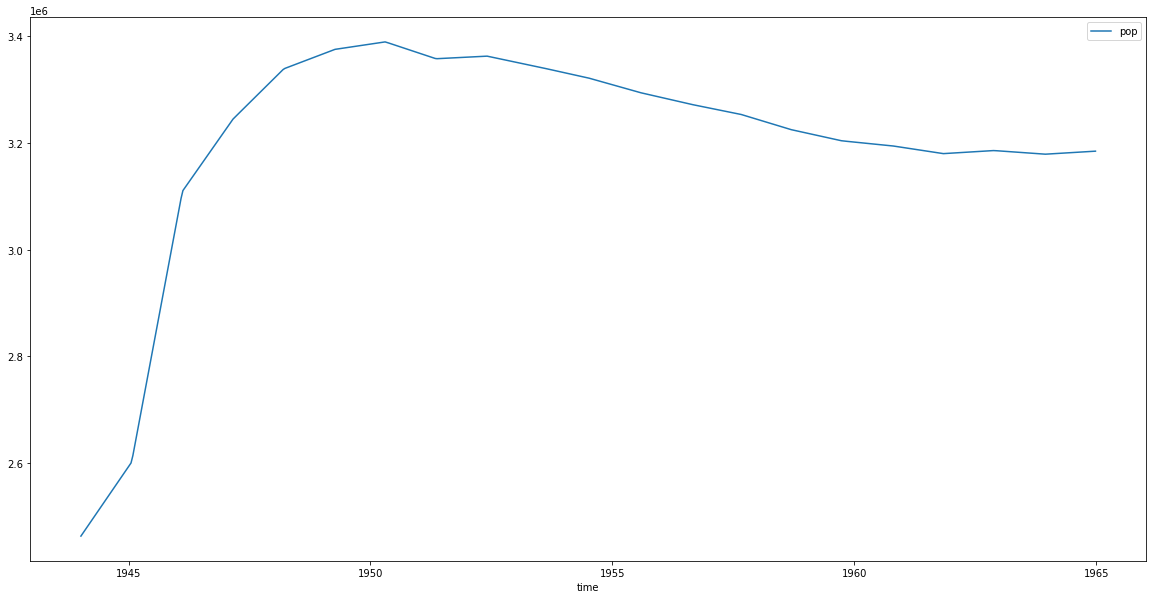

In [681]:
data.plot(x ='time', y='pop',figsize=(20,10))

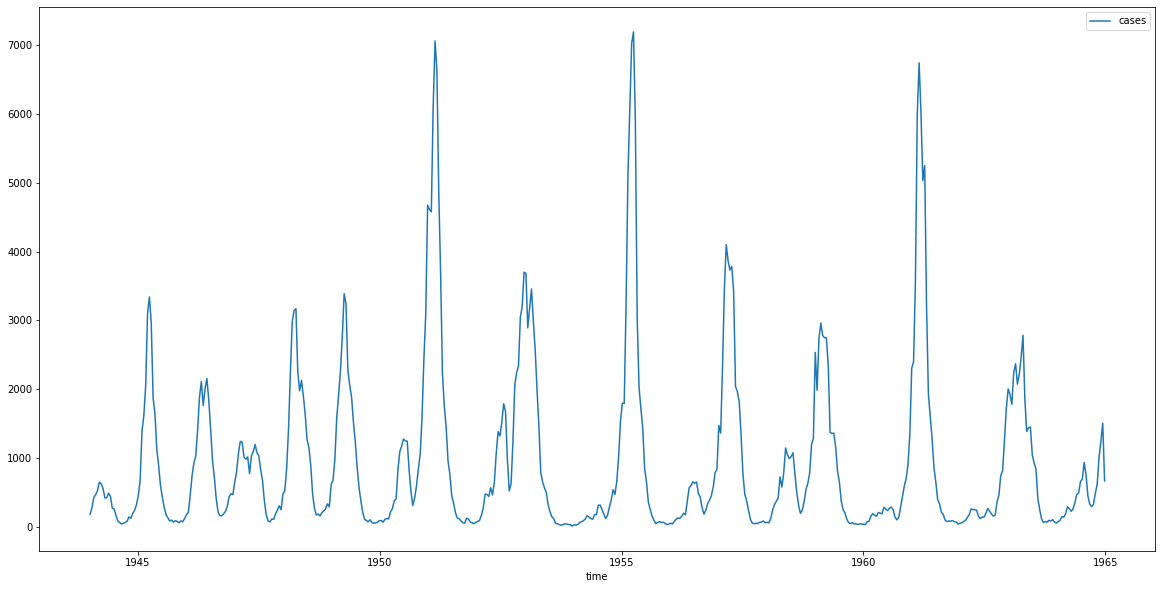

In [682]:
data.plot(x ='time', y='cases',figsize=(20,10))

# **Selecionando um ano específico para análise**

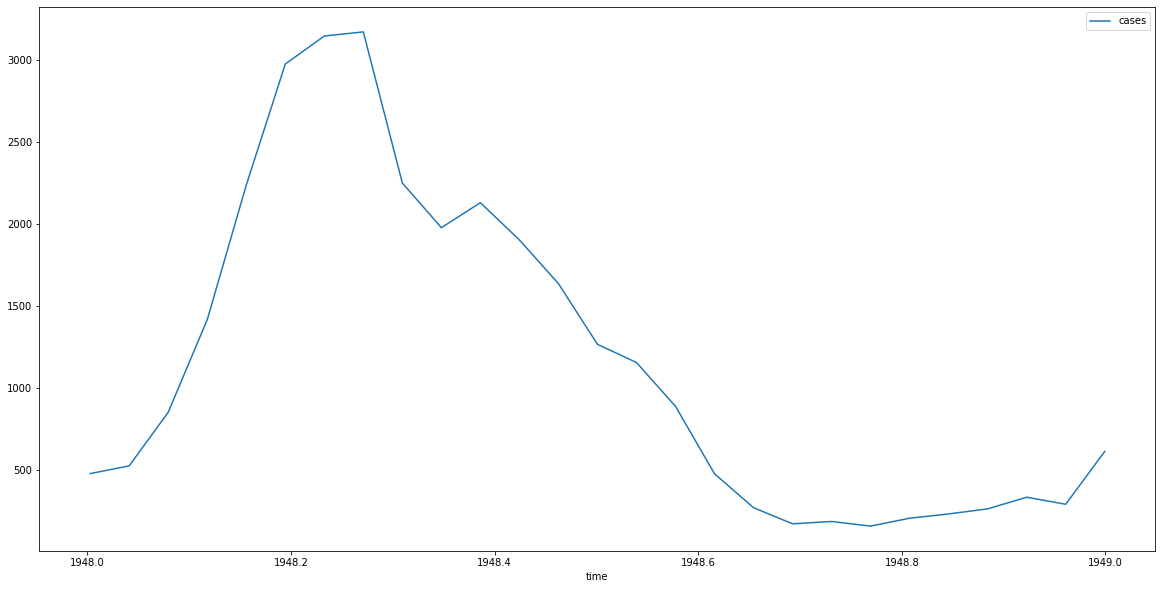

In [683]:
is_1948 =  data['time'].astype(int) == 1948
LD48 = data[is_1948]
LD48.head()
LD48.plot(x ='time', y='cases',figsize=(20,10))

# **Os dados**

Conhecemos o número de casos, os nascimentos e a população total. Podemos determinar os demais valores a partir da relação $S(t)+I(t)+R(t)=N$ onde **N** vamos considerar a população.

In [0]:
s_array = LD48[["cases", "births", "pop","time"]].to_numpy()
s_array[:,0:]
Id = s_array[:,0]
Bd = s_array[:,1]
Sd = s_array[:,2] - Id + Bd 
t  =  s_array[:,3]
t  =  np.rint((t - 1948)*365)



In [0]:
def double_to_date(raw_val=None, initial_year=1948):
    #raw_val = data["time"].to_list()
    year, days, hours, minutes = [], [], [], []
    date_list, ref_date = [], datetime.date(year=initial_year, month=1, day=1)
    for val in raw_val:
        val = 365 * (val - initial_year)
        days = int(val)
        val = 24 * (val - days)
        hours = int(val)
        val = 60 * (val - hours)
        minutes = int(val)
        date_delta = datetime.timedelta(days=(days), hours=hours, minutes=minutes)
        date_list.append(ref_date + date_delta)
    return date_list

In [686]:
tempo = double_to_date(LD48["time"].to_list(), initial_year=1948)
LD48['tempo'] = tempo
LD48.set_index('tempo')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,cases,births,pop
tempo,,,,
1948-01-01,1948.002738,477,2413.681268,3.320521e+06
1948-01-15,1948.041068,524,2399.787301,3.323961e+06
1948-01-29,1948.079398,851,2385.893334,3.327402e+06
1948-02-12,1948.117728,1415,2371.999367,3.330843e+06
1948-02-26,1948.156057,2235,2358.105400,3.334283e+06
1948-03-11,1948.194387,2973,2344.211433,3.337724e+06
1948-03-25,1948.232717,3144,2335.061103,3.339898e+06
1948-04-08,1948.271047,3169,2329.073196,3.341228e+06
1948-04-22,1948.309377,2248,2323.085290,3.342557e+06


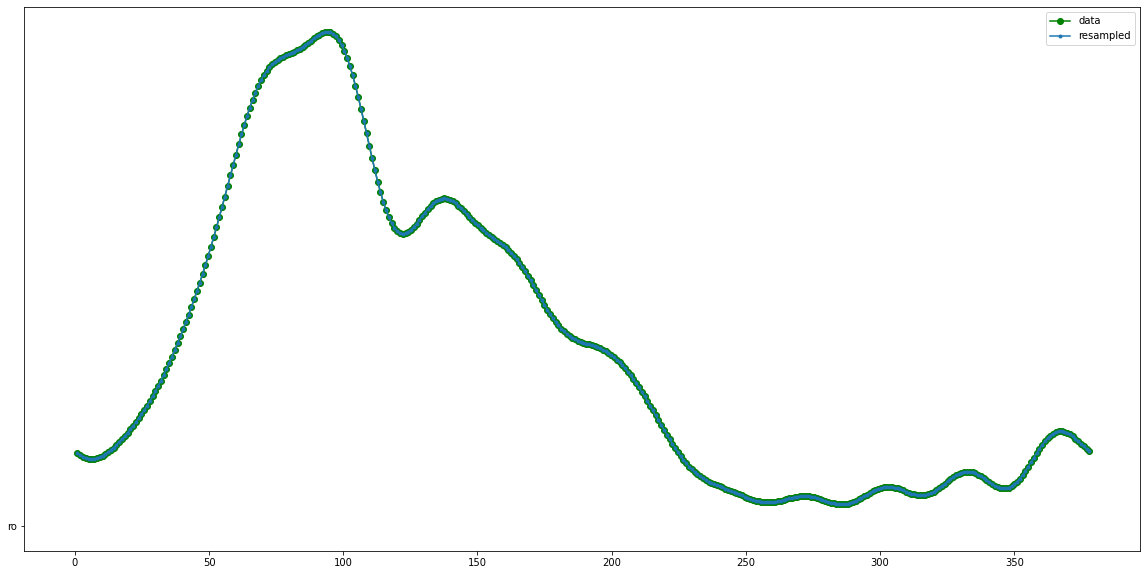

In [709]:
from scipy import signal
aux = signal.resample(Id,365,t)
In = aux[0]
tn = aux[1]

fig = plt.figure(facecolor='w',figsize=(20,10))
plt.plot(t, Id, 'go-', tn, In, '.-', 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

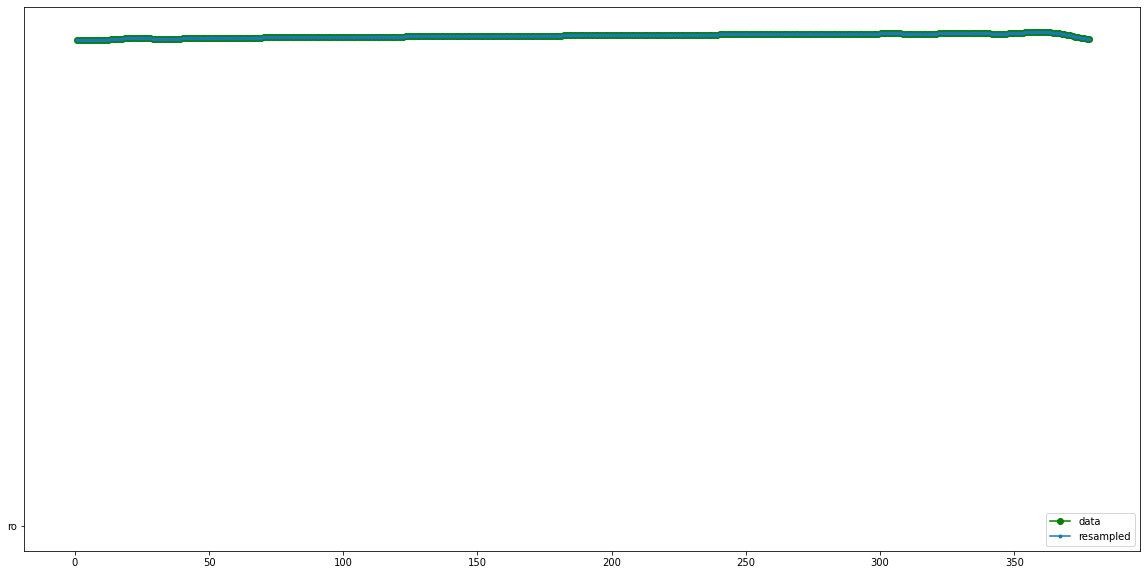

In [708]:
aux = signal.resample(Sd,365,t)
Sn = aux[0]
tn = aux[1]

fig = plt.figure(facecolor='w',figsize=(20,10))
plt.plot(t, Sd, 'go-', tn, Sn, '.-', 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [0]:
Id = In
Sd = Sn 
t = tn

# **O problema**









O conjunto de equações diferenciais que caracteriza o modelo é descrito abaixo. No modelo $\beta - \text{representa a taxa de transmissão ou taxa efetiva de contato} $  e $r - \text{a taxa de remoção ou recuperação.}$ 


$$ \begin{split}
   \frac{dS(t)}{dt} & = -\beta S(t) I(t) \\
   \frac{dI(t)}{dt} & = \beta S(t) I(t) - rI(t)  \\
   \frac{dR(t)}{dt} & = r I(t)
   \end{split}$$

   Gostaríamos de identificar quais parâmetros $\beta$ e $r$ resultam num melhor ajuste do modelo para os dados de **S**,**I** e **R**

In [0]:
def SIRmodel(y, t, paras):
    """
    Sistema de equações diferenciais
    """
    S = y[0]
    I = y[1]
    R = y[2]

    try:
        Beta = paras['Beta'].value
        r = paras['r'].value

    except KeyError:
        Beta, r = paras

    # Equações

    Sdot = -(Beta * S * I)
    Idot = (Beta * S * I)  - r * I
    Rdot = r * I
    return [Sdot, Idot, Rdot]

# **Obtendo** $y_s(\theta,k) = [S \; I \: R]$



O trecho a seguir retorna os valores sintetizados $y_s(\theta,k) = [S \; I \: R]$ representa o dado sintetizado a partir de um modelo sintetizado para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \beta \; \; r]^T$. A partir de uma condição inicial $y_0$.



In [0]:
def SIRsolve(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(SIRmodel, x0, t, args=(paras,))
    return x

# **Condições inicias** - $y_0$ e $\theta_0$

In [0]:
# Valores iniciais 
I0 = Id[0] 
S0 = Sd[0]
R0 = 0

# initial conditions
x10 = S0
x20 = I0
x30 = R0
y0 = [x10, x20, x30]

# measured data
t_measured = t
x2_measured = np.concatenate([Id])

#plt.figure()
#plt.scatter(x2_measured, marker='o', color='b', label='measured data', s=75)

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('Beta', value=5e-9, min=1e-11, max=1)
params.add('r', value=5e-1, min=1e-3, max=1)

# **Estimativa de parâmetros**

Para estimarmos os parâmetros do modelo $\mathbf{\beta}$ e $\mathbf{r}$, vamos utilizar  inicialmente o método de mínimos quadrados. Podemos então formular o problema a partir da Equação abaixo. Na Equação $y_m(k)$ representa o dado real em cada amostra $k$; $y_s(\theta,k)$ representa o **valor estimado** a partir da simulação do modelo para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \beta \; \; r]^T$. 

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

A equação formula a pergunta: quais os valores de $beta$ e $r$ que minizam o erro quadrático quando comparados com os dados reais.

In [0]:
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['x10'].value, paras['x20'].value, paras['x30'].value
    model = SIRsolve(t, x0, paras)

    # you only have data for one of your variables
    # x2_model = np.concatenate(model[:, 1])
    x2_model =model[:, 1]
    return (x2_model - data).ravel()


# **Minimização da função custo**

In [0]:
# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = SIRsolve(t_measured, y0, result.params)


# **Visualização**

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 87
    # data points      = 365
    # variables        = 2
    chi-square         = 43832344.8
    reduced chi-square = 120750.261
    Akaike info crit   = 4273.03460
    Bayesian info crit = 4280.83440
[[Variables]]
    x10:   3322458 (fixed)
    x20:   477 (fixed)
    x30:   0 (fixed)
    Beta:  2.1682e-07 +/- 1.6783e-09 (0.77%) (init = 5e-09)
    r:     0.69267150 +/- 0.00538615 (0.78%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(Beta, r) =  0.999


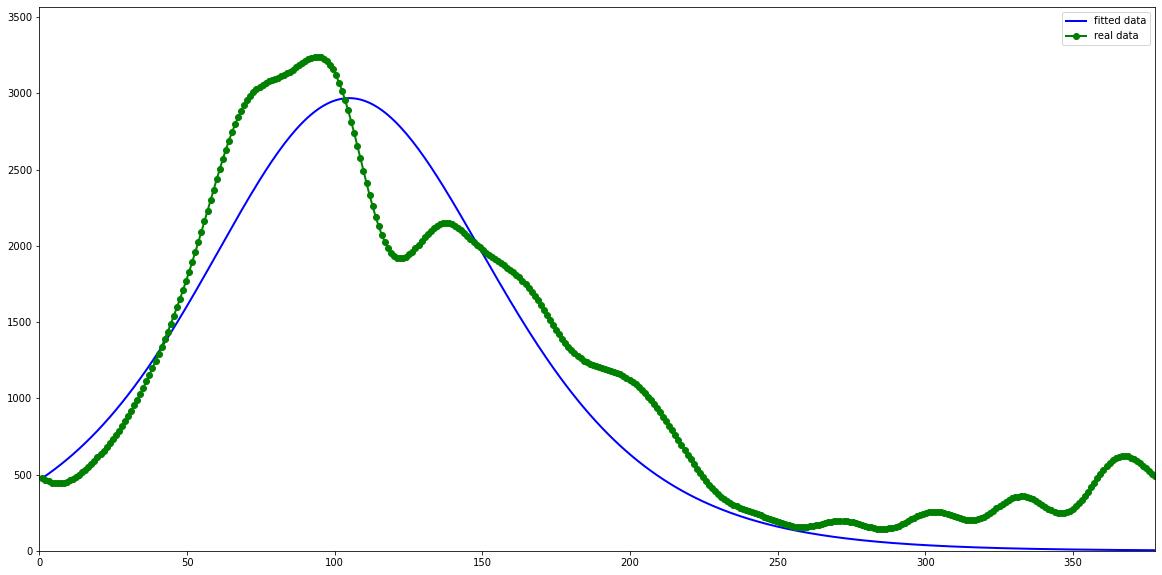

In [706]:
# plot fitted data
fig = plt.figure(facecolor='w',figsize=(20,10))
plt.plot(t_measured, data_fitted[:, 1], '-', linewidth=2, color='blue', label='fitted data')
plt.plot(t_measured, Id, '-', linewidth=2, color='green', label='real data',  marker='o')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(Id)])
# display fitted statistics
report_fit(result)

plt.show()